In [1]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook

data_path = os.path.dirname(os.path.dirname(os.getcwd()))

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']
#subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
#                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale',
#                'Silvia','Silvia2','Tommaso']

# epoching and saving

In [16]:
# extract trials of tmax second and remove the wrong answer trials and seperate them in three conditions
Tmin = 0
Tmax = 4.51
trial_len = 3

for s in subject_name:
    raw_fname = data_path + '/analysis/python/data/'+s+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/analysis/behaviour/data/subject/'+s+'_behaviour.mat'
    mat = scipy.io.loadmat(raw_fname)
    epochs = listen_italian_functions.epoch(raw, mat,Tmin, Tmax)
    save_path = data_path + '/analysis/python/data/'+s+'-coh-epo-'+str(Tmin)+'-'+str(Tmax)+'-trialLen-'+str(trial_len)+'.fif'
    epochs.save(save_path)
    print('----------------------------------------------------------------------------------------------------------------'+s)



Opening raw data file D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\Silvia_raw.fif...
    Range : 39578 ... 1131726 =     39.578 ...  1131.726 secs
Ready.
Reading 0 ... 1092148  =      0.000 ...  1092.148 secs...
800 events found
Event IDs: [100 105 106 200]
200 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169

# Read the epoches

In [2]:
Tmin = 0
Tmax = 3.51
trial_len = 2
remove_first = 0.1 #seconds

GA_epoches = []
for s in subject_name:
    save_path = data_path + '/analysis/python/data/'+s+'-coh-epo-'+str(Tmin)+'-'+str(Tmax)+'-trialLen-'+str(trial_len)+'.fif'
    epochs = mne.read_epochs(save_path)
    GA_epoches.append(epochs)
    print('----------------------------------------------------------------------------------------------------------------'+s)


This filename (D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Alice-coh-epo-0-3.51-trialLen-2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif or -epo.fif.gz
Reading D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Alice-coh-epo-0-3.51-trialLen-2.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    3507.50 ms
        0 CTF compensation matrices available
124 matching events found
No baseline correction applied
124 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
----------------------------------------------------------------------------------------------------------------Alice
This filename (D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Andrea-coh-epo-0-3.51-trialLen-2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif or -epo.fif.gz
Read

This filename (D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Sara-coh-epo-0-3.51-trialLen-2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif or -epo.fif.gz
Reading D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Sara-coh-epo-0-3.51-trialLen-2.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    3507.50 ms
        0 CTF compensation matrices available
120 matching events found
No baseline correction applied
120 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
----------------------------------------------------------------------------------------------------------------Sara
This filename (D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Silvia-coh-epo-0-3.51-trialLen-2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif or -epo.fif.gz
Reading

In [3]:
condition = ['Hyper','Normal','Hypo']
frames = []
for s in range(0,len(subject_name)):
    df = pd.DataFrame({'Condition':'Hyper','Subject':subject_name[s],'noTrials':GA_epoches[s]['hyper'].get_data().shape[0]},index=[s])
    df = df.append(pd.DataFrame({'Condition':'Normal','Subject':subject_name[s],'noTrials':GA_epoches[s]['normal'].get_data().shape[0]},index=[s]))
    df = df.append(pd.DataFrame({'Condition':'Hypo','Subject':subject_name[s],'noTrials':GA_epoches[s]['hypo'].get_data().shape[0]},index=[s]))
    frames.append(df)
    
data=pd.concat((frames),axis=0)

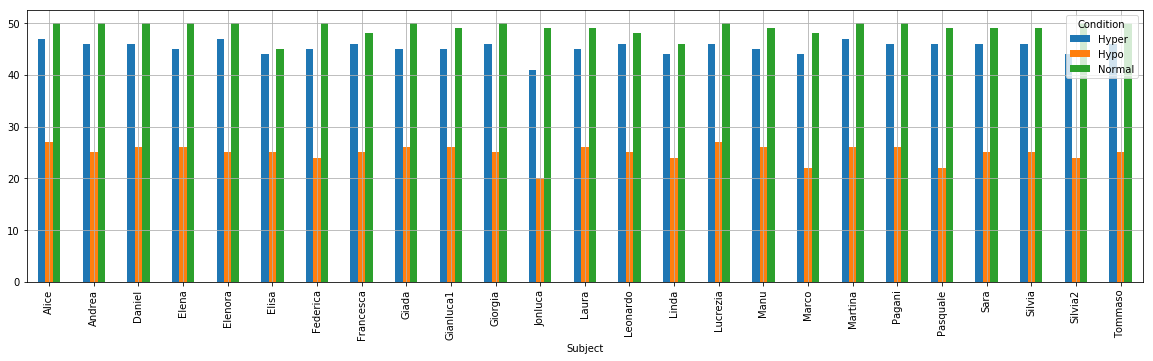

In [4]:
a=data.groupby(['Subject','Condition']).sum()['noTrials'].unstack().plot(kind='bar',figsize=(20,5),grid=True)

# Measuring the coherence

In [ ]:
remove_first = 0#seconds

# let's explore some frequency bands
iter_freqs = [
    ('Delta', 1, 3),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 40)
]

iter_freqs = [
    ('fr', 1, 3),
    ('fr', 2, 4),
    ('fr', 3, 5),
    ('fr', 4, 6),
    ('fr', 5, 7),
    ('fr', 6, 8),
    ('fr', 7, 9),
    ('fr', 8, 10),
    ('fr', 9, 11),
    ('fr', 10, 12)
]
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['Hyper','Normal','Hypo']
delay = np.arange(0,1.1,0.1)


indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features)))   

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
eeg_channles = np.setdiff1d(GA_epoches[0].ch_names, extra_channels)
event_id = {'hyper': 1,'normal': 2,'hypo': 3}
ch_types = np.repeat('eeg', len(features)+59)
ch_names = np.hstack((eeg_channles,features))        
info = mne.create_info(ch_names = ch_names.tolist(),ch_types = ch_types,sfreq = GA_epoches[0].info['sfreq'])
ch_names = np.setdiff1d(extra_channels,features)
        
for s in tqdm_notebook(range(0,len(subject_name)), desc='Subjects'):
    frames = []
    for d in tqdm_notebook(delay, desc='Delay'):        

        epoch = listen_italian_functions.coherence_preprocess_delay(GA_epoches[s],remove_first,d,trial_len,
                                                                    extra_channels,eeg_channles,info,ch_names,event_id)

        
        for band, fmin, fmax in iter_freqs:
            a = band+ ' '+str(fmin)+' - '+str(fmax)+'Hz'                
            hyper, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch['hyper'],fmin, fmax,indices)
            normal, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch['normal'],fmin, fmax,indices)
            hypo, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch['hypo'],fmin, fmax,indices)
            allC, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch,fmin, fmax,indices)

            hyper = np.split(hyper, len(features))
            normal = np.split(normal, len(features))
            hypo = np.split(hypo, len(features))
            allC = np.split(allC, len(features))

            for f in range(0,len(features)):
                feature = features[f]
                df = pd.DataFrame({'Condition':'Hyper','Freq':a,'Delay':d,'Feature':feature,
                                           'noTrials':GA_epoches[s]['hyper'].get_data().shape[0],
                                           'Subject':subject_name[s],'Data':[hyper[f].flatten()]})
                df = df.append(pd.DataFrame({'Condition':'Normal','Freq':a,'Delay':d,'Feature':feature,
                                             'noTrials':GA_epoches[s]['normal'].get_data().shape[0],
                                             'Subject':subject_name[s],'Data':[normal[f].flatten()]}))
                df = df.append(pd.DataFrame({'Condition':'Hypo','Freq':a,'Delay':d,'Feature':feature,
                                             'noTrials':GA_epoches[s]['hypo'].get_data().shape[0],
                                             'Subject':subject_name[s],'Data':[hypo[f].flatten()]}))
                df = df.append(pd.DataFrame({'Condition':'All','Freq':a,'Delay':d,'Feature':feature,
                                             'noTrials':GA_epoches[s].get_data().shape[0],
                                             'Subject':subject_name[s],'Data':[allC[f].flatten()]}))
                frames.append(df)
        print(d)
        
    data=pd.concat((frames),axis=0)
    save_path = data_path + '/analysis/python/data/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(remove_first)+'s-'+subject_name[s]
    data.to_pickle(save_path)

HBox(children=(IntProgress(value=0, description='Subjects', max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Delay', max=11), HTML(value='')))

124 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Connectivity computation...
    computing connectivity for 413 connections
    using t=0.000s..2.000s for estimation (801 points)
fmin=1.000 Hz corresponds to 2.002 < 5 cycles based on the epoch length 2.002 sec, need at least 5.000 sec epochs or fmin=2.497. Spectrum estimate will be unreliable.
    frequencies: 1.5Hz..3.0Hz (4 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing

    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45
    computing connectivity for epoch 46
    computing connectivity for epoch 47
    computing connectivity for epoch 48
    computing connectivity for epoch 49
    computing connectivity for epoch 50
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 413 connections
    using t=0.000s..2.000s for estimation (801 points)
fmin=2.000 Hz corresponds to 4.005 < 5 cycles based on the epoch length 2.002 

    computing connectivity for epoch 51
    computing connectivity for epoch 52
    computing connectivity for epoch 53
    computing connectivity for epoch 54
    computing connectivity for epoch 55
    computing connectivity for epoch 56
    computing connectivity for epoch 57
    computing connectivity for epoch 58
    computing connectivity for epoch 59
    computing connectivity for epoch 60
    computing connectivity for epoch 61
    computing connectivity for epoch 62
    computing connectivity for epoch 63
    computing connectivity for epoch 64
    computing connectivity for epoch 65
    computing connectivity for epoch 66
    computing connectivity for epoch 67
    computing connectivity for epoch 68
    computing connectivity for epoch 69
    computing connectivity for epoch 70
    computing connectivity for epoch 71
    computing connectivity for epoch 72
    computing connectivity for epoch 73
    computing connectivity for epoch 74
    computing connectivity for epoch 75


    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45
    computing connectivity for epoch 46
    computing connectivity for epoch 47
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 413 connections
    using t=0.000s..2.000s for estimation (801 points)
    frequencies: 5.5Hz..7.0Hz (4 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoc

# Measure the coherence in specific delay and shifting the eeg and speech from speech onset

In [ ]:
remove_first = [0,0.1,0.2,0.3,0.4,0.5] #seconds

for rf in remove_first:
        # let's explore some frequency bands
    iter_freqs = [
        ('Delta', 1, 3),
        ('Theta', 4, 7),
        ('Alpha', 8, 12),
        ('Beta', 13, 25),
        ('Gamma', 30, 40)
    ]
    features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    condition = ['Hyper','Normal','Hypo']
    delay = np.arange(0,1.1,0.1)
    delay = [0,0.1,0.2]
    delay = np.add(delay,0.5) #shift to below algorithm format
    indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features)))  
    extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    eeg_channles = np.setdiff1d(GA_epoches[0].ch_names, extra_channels)
    event_id = {'hyper': 1,'normal': 2,'hypo': 3}
    ch_types = np.repeat('eeg', len(features)+59)
    ch_names = np.hstack((eeg_channles,features))        
    info = mne.create_info(ch_names = ch_names.tolist(),ch_types = ch_types,sfreq = GA_epoches[0].info['sfreq'])
    ch_names = np.setdiff1d(extra_channels,features)

    for s in tqdm_notebook(range(0,len(subject_name)), desc='Subjects'):
        frames = []
        for d in tqdm_notebook(delay, desc='Delay'):        

            epoch = listen_italian_functions.coherence_preprocess_delay(GA_epoches[s],rf,d,trial_len,
                                                                        extra_channels,eeg_channles,info,ch_names,event_id)


            for band, fmin, fmax in iter_freqs:
                a = band+ ' '+str(fmin)+' - '+str(fmax)+'Hz'                
                hyper, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch['hyper'],fmin, fmax,indices)
                normal, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch['normal'],fmin, fmax,indices)
                hypo, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch['hypo'],fmin, fmax,indices)
                allC, freqs, times, n_epochs, n_tapers = listen_italian_functions.coherence_measure(epoch,fmin, fmax,indices)

                hyper = np.split(hyper, len(features))
                normal = np.split(normal, len(features))
                hypo = np.split(hypo, len(features))
                allC = np.split(allC, len(features))

                for f in range(0,len(features)):
                    feature = features[f]
                    df = pd.DataFrame({'Condition':'Hyper','Freq':a,'Delay':d,'Feature':feature,
                                               'noTrials':GA_epoches[s]['hyper'].get_data().shape[0],
                                               'Subject':subject_name[s],'Data':[hyper[f].flatten()]})
                    df = df.append(pd.DataFrame({'Condition':'Normal','Freq':a,'Delay':d,'Feature':feature,
                                                 'noTrials':GA_epoches[s]['normal'].get_data().shape[0],
                                                 'Subject':subject_name[s],'Data':[normal[f].flatten()]}))
                    df = df.append(pd.DataFrame({'Condition':'Hypo','Freq':a,'Delay':d,'Feature':feature,
                                                 'noTrials':GA_epoches[s]['hypo'].get_data().shape[0],
                                                 'Subject':subject_name[s],'Data':[hypo[f].flatten()]}))
                    df = df.append(pd.DataFrame({'Condition':'All','Freq':a,'Delay':d,'Feature':feature,
                                                 'noTrials':GA_epoches[s].get_data().shape[0],
                                                 'Subject':subject_name[s],'Data':[allC[f].flatten()]}))
                    frames.append(df)
            print(d)

        data=pd.concat((frames),axis=0)
        save_path = data_path + '/analysis/python/data/shift/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(rf)+'s-'+subject_name[s]
        data.to_pickle(save_path)